<a href="https://colab.research.google.com/github/tsilva/aiml-notebooks/blob/main/misc/wip-generate-mnist-with-vaes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate MNIST digits with Variational Autoencoders (VAEs)

In this notebook, we'll dive into **Variational Autoencoders (VAEs)** to reconstruct and generate MNIST digits. Unlike regular autoencoders, VAEs learn a structured, probabilistic latent space, enabling us to sample and create new digits that resemble the training data. 🤩

**Key Differences:**

*   **Traditional Autoencoders:** Optimize the latent space *solely* for reconstruction, which could lead to an irregular, less useful space for generation.
*   **VAEs:** Model latent features with probability distributions (e.g., Gaussian), allowing smooth interpolation and the generation of novel samples.

By balancing reconstruction with a coherent latent space, VAEs offer versatile applications like data synthesis and exploration. Let's get started! 🚀


## Setup

Let's install the necessary libraries. 👇


In [1]:
%pip install torch # Our main framework for building and training the neural network.
%pip install datasets # A handy way to grab the MNIST dataset without manual downloads.
%pip install matplotlib # For plotting digits and latent spaces.
%pip install opencv-python-headless # Helps us create videos of generated digits.
%pip install tsilva-notebook-utils # Personal utils to facilitate notebook authoring

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [10]:
from tsilva_notebook_utils import render_video, render_videos

render_videos([
    ([np.random.randint(0, 64, (64, 64, 3), dtype=np.uint8) for _ in range(10)], "Video 1"),
    ([np.random.randint(64, 128, (64, 64, 3), dtype=np.uint8) for _ in range(10)], "Video 2"),
    ([np.random.randint(128, 256, (64, 64, 3), dtype=np.uint8) for _ in range(10)], "Video 3"),
])

Video 1,Video 2,Video 3


We'll use the Hugging Face `datasets` library to load the MNIST dataset. 📚 Since we're using PyTorch, we'll create a custom `Dataset` adapter to ensure compatibility.

More info on [Hugging Face Datasets](https://huggingface.co/docs/datasets/index) and [PyTorch Datasets](https://pytorch.org/docs/stable/data.html).


In [ ]:
import multiprocessing
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the MNIST Dataset adapter to convert Hugging Face dataset into PyTorch-compatible format
class MNISTDataset(Dataset):
    def __init__(self, hf_dataset, split):
        # Store the dataset split (train or test)
        self.data = hf_dataset[split]
        # Define transformation to convert images to tensors
        self.transform = transforms.ToTensor()

    def __len__(self):
        # Return the total number of samples in the split
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch image and label at the given index
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        # Apply transformation and return as tensor, label pair
        return self.transform(image), label

def build_dataset_loaders(dataset_name, train_batch_size=1024, test_batch_size=10):
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name)

    # Wrap train and test splits in the custom adapter
    train_dataset = MNISTDataset(dataset, "train")
    test_dataset = MNISTDataset(dataset, "test")

    # Create DataLoader for the training set
    # Larger batches reduce gradient variance and can speed up training per epoch,
    # but may hinder convergence if too large (e.g., if batch equals dataset size,
    # gradients would be constant, preventing optimal convergence); smaller batches
    # introduce noise that can help escape local minima but may lead to suboptimal
    # optimization if overly noisy.
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,  # Shuffling ensures unbiased gradient updates by randomizing data order (e.g., without shuffling, a step might optimize for only one digit type)
        num_workers=multiprocessing.cpu_count(),  # Use all CPU cores for data loading
        pin_memory=True  # Move data to pinned memory for asynchronous GPU fetching
    )

    # Create DataLoader for the test set
    # (We won’t use it for validation loss during training since the loss is reconstruction-based,
    # but it’s convenient for later experimentation)
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,  # No shuffling needed for test set
        num_workers=multiprocessing.cpu_count(),
        pin_memory=False  # No pinned memory required for test set
    )

    # Return the DataLoaders
    return train_loader, test_loader

# Create dataset loaders
DATASET_NAME = "mnist"
TRAIN_BATCH_SIZE = 1024
train_loader, test_loader = build_dataset_loaders(DATASET_NAME, train_batch_size=TRAIN_BATCH_SIZE)

# Load single batch and print its structure for verification
for x, y in train_loader:
    print(f"Train batch - x shape: {x.shape}, y shape: {y.shape}")
    break

Train batch - x shape: torch.Size([1024, 1, 28, 28]), y shape: torch.Size([1024])


After loading a batch, we have:

*   `x` (input tensor): Shape `(batch_size, n_channels, width, height)` representing the images.
*   `y` (labels): Shape `(batch_size)` containing the digit labels.

Let's visualize a sample digit from `x` to ensure our data is loaded correctly. 👇


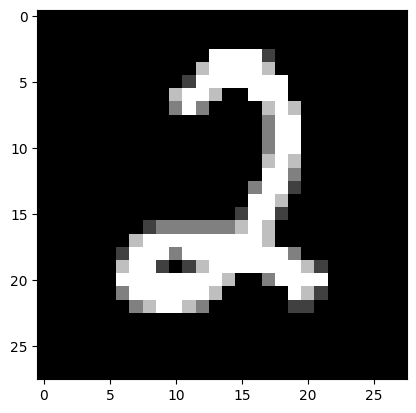

In [ ]:
import matplotlib.pyplot as plt
digit = x[0] # Retrieve the first sample from the batch
digit_p = digit.permute(1, 2, 0) # Swap dimensions such that n_channels becomes the last dimension (expected by matplotlib)
plt.imshow(digit_p, cmap="gray") # Draw the digit

Let's confirm our hardware setup before building the VAE. 💻 This will help optimize our training speed.


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}, GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

Using device: cuda, GPU: NVIDIA A100-SXM4-40GB


## Build Model

Now, let's build our **Variational Autoencoder (VAE)**! 🏗️ A VAE consists of three main components:

*   **Encoder:** Compresses the 28x28 MNIST image into a compact "code" (latent space) by learning its key features.
*   **Latent Layer:** Introduces a probabilistic element, enabling us to sample new codes instead of just memorizing the training data.
*   **Decoder:** Transforms the codes back into images, aiming to reconstruct the originals or generate entirely new digits.

Unlike regular autoencoders that might overfit, the VAE's *probabilistic latent space* lets us generate new, unseen samples! ✨


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

IMAGE_WIDTH = digit.shape[1]
IMAGE_HEIGHT = digit.shape[2]
INPUT_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT
OUTPUT_SIZE = INPUT_SIZE

def build_model(hidden_dim=256, n_latent_features=2):
    # Define the Variational Autoencoder model class
    class VAE(nn.Module):
        def __init__(self):
            super(VAE, self).__init__()

            # Encoder compresses input to hidden layer
            self.encoder = nn.Sequential(
                nn.Linear(INPUT_SIZE, hidden_dim),
                nn.ReLU()
            )

            # Latent layers learn mean and log variance to model probability distributions
            # of features rather than fixed feature values.
            # NOTE: Log variance is used (instead of variance or standard deviation)
            # as it can be any real number, ensuring a positive variance via
            # `variance = exp(log_var)` and avoiding invalid negative values during training.
            self.mean_layer = nn.Linear(hidden_dim, n_latent_features)
            self.log_variance_layer = nn.Linear(hidden_dim, n_latent_features)

            # Decoder reconstructs image from latent features
            self.decoder = nn.Sequential(
                nn.Linear(n_latent_features, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, OUTPUT_SIZE)
            )

        def encode(self, x):
            # Compress input to hidden representation
            h = self.encoder(x)

            # Output mean and log variance of latent distribution
            mean = self.mean_layer(h)
            log_variance = self.log_variance_layer(h)
            return mean, log_variance

        def reparameterize(self, mean, log_variance):
            # Compute standard deviation from log variance
            standard_deviation = torch.exp(0.5 * log_variance)

            # Sample noise from standard normal distribution
            # (NOTE: std only defines tensor shape, not sampling distribution)
            noise = torch.randn_like(standard_deviation)

            # Reparameterize: scale and shift noise to sample from the learned distribution,
            # expressing the sample as a deterministic function of `mean` and `log_variance` plus noise,
            # enabling gradients for backpropagation (reparameterization trick)
            return mean + noise * standard_deviation

        def decode(self, z):
            # Reconstruct image from latent representation
            return self.decoder(z)

        def forward(self, x):
            # Flatten input and encode to latent distribution
            mean, log_variance = self.encode(x.view(-1, INPUT_SIZE))

            # Sample from latent distribution using reparameterization
            z = self.reparameterize(mean, log_variance)

            # Decode latent sample back to image
            reconstructed_x = self.decode(z)

            # Return reconstruction and distribution params for loss
            return reconstructed_x, mean, log_variance

    # Create and send it to device
    model = VAE()
    model.to(DEVICE)

    # Return model
    return model

# Build the model
N_LATENT_FEATURES = 2
HIDDEN_DIM = 256
model = build_model(hidden_dim = HIDDEN_DIM, n_latent_features = N_LATENT_FEATURES)

## Train Model

We'll train the VAE using a custom loss function: 🤓

*   **Reconstruction Loss:** Binary cross-entropy measures how well the output matches the input.
*   **KL Divergence:** A regularization term aligns the latent distributions with a standard normal distribution (mean 0, variance 1).

The `beta` parameter balances these terms. We'll use the Adam optimizer for efficient training. ⚙️


In [ ]:
import torch
import torch.optim as optim
from torch import nn

# Define the VAE loss function combining reconstruction and regularization terms
def loss_function(reconstructed_x, x, mean, log_variance, beta=1.0):
    # Binary Cross-Entropy: Measures reconstruction error.
    # - "Binary" since it compares values between 0 and 1 (e.g., pixel intensities).
    # - "Cross-entropy" because it penalizes predictions based on how surprising the truth is,
    #   with larger penalties for confident wrong guesses than uncertain correct ones.
    # - "With logits" fuses sigmoid and loss into one efficient step.
    # - Sums (not averages) loss to balance with KLD term magnitude.
    bce_loss = nn.functional.binary_cross_entropy_with_logits(reconstructed_x, x.view(-1, OUTPUT_SIZE), reduction='sum')

    # Kullback-Leibler Divergence: Regularizes latent space by aligning `mean` and `log_variance`
    # with a standard normal distribution (mean 0, variance 1).
    # - `mean.pow(2)` penalizes means deviating from 0.
    # - `1 + log_variance - log_variance.exp()` minimizes KLD when variance is 1, penalizing deviations above or below.
    kld_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

    # Total loss: reconstruction + regularization
    return bce_loss + beta * kld_loss

def train(model, n_epochs=50, learning_rate=0.001, loss_kwargs={}):
    # Create the optimizer to adjust weights using backpropagated gradients
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Set model to training mode (affects dropout and batch norm if present,
    # though not used here, it’s best practice)
    model.train()

    # Train the model for the specified number of epochs
    for epoch in range(1, n_epochs + 1):
        total_train_loss = 0

        # Iterate over batches in the training loader
        for x, _ in train_loader:
            # Send the input batch to the specified device (e.g., GPU or CPU)
            x = x.to(DEVICE)

            # Zero out gradients to prevent accumulation from previous batches
            optimizer.zero_grad()

            # Forward the batch through the model to get reconstructions and latent parameters
            reconstructed_x, mean, log_variance = model(x)

            # Compute the loss, balancing reconstruction accuracy and latent distribution regularization
            loss = loss_function(reconstructed_x, x, mean, log_variance)

            # Backpropagate the loss to compute gradients
            loss.backward()

            # Update model weights using the computed gradients
            optimizer.step()

            # Accumulate the batch loss for epoch-level tracking
            total_train_loss += loss.item()

        # Calculate and print the average training loss for the epoch
        train_loss = total_train_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}, Loss: {train_loss:.4f}')

# Train model
train(model, n_epochs=20, learning_rate=0.001, loss_kwargs={"beta" : 1.0})

Epoch 1, Loss: 263.7276
Epoch 2, Loss: 193.5095
Epoch 3, Loss: 185.5831
Epoch 4, Loss: 181.3296
Epoch 5, Loss: 177.9615
Epoch 6, Loss: 174.9975
Epoch 7, Loss: 172.4876
Epoch 8, Loss: 170.4343
Epoch 9, Loss: 168.6638
Epoch 10, Loss: 166.9415
Epoch 11, Loss: 165.3817
Epoch 12, Loss: 164.0272
Epoch 13, Loss: 162.8560
Epoch 14, Loss: 161.8573
Epoch 15, Loss: 160.9084
Epoch 16, Loss: 160.1569
Epoch 17, Loss: 159.5381
Epoch 18, Loss: 158.9581
Epoch 19, Loss: 158.3857
Epoch 20, Loss: 158.0413


## Evaluate Model

Now that our model is trained, let's see how well it can reconstruct digits from the test set. We'll compare the reconstructed digits to the originals. 🖼️


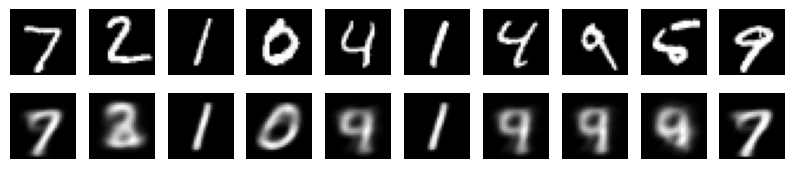

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_reconstructions(num_samples=10):
    # Set model to evaluation mode (disables dropout and changes batch norm behavior,
    # though not used here, it's best practice)
    model.eval()

    # Visualize original vs reconstructed images without gradient tracking
    with torch.no_grad():
        # Retrieve a single batch from the test dataset
        x, _ = next(iter(test_loader))

        # Send input batch to the specified device (e.g., GPU or CPU)
        x = x.to(DEVICE)

        # Forward the batch through the model to get reconstructed images
        reconstructed_x, _, _ = model(x)

        # Apply sigmoid to rescale logits to [0-1] grayscale intensities
        # (model outputs logits since it has no sigmoid layer)
        reconstructed_x = torch.sigmoid(reconstructed_x)

        # Create a figure with 2 rows (original and reconstructed) and num_samples columns
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples, 2))

        # Plot original and reconstructed images side-by-side
        for i in range(num_samples):
            # Original image: move to CPU, reshape to 28x28, display in grayscale
            axes[0, i].imshow(x[i].cpu().view(28, 28), cmap='gray')
            axes[0, i].axis('off')  # Hide axes for cleaner display

            # Reconstructed image: move to CPU, reshape to 28x28, display in grayscale
            axes[1, i].imshow(reconstructed_x[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')  # Hide axes for cleaner display

        # Display the plot
        plt.show()

plot_reconstructions()

Time to generate some new digits! 🎉 We can use the VAE's latent space in two ways:

*   **Sample Randomly:** Draw samples from the learned latent distribution to create novel digits. 🎲
*   **Interpolate:** Create smooth transitions between latent points to generate sequences of evolving digits. 🔄

Let's render the results as a video to visualize the generative process. 🎬


In [ ]:
import torch
import numpy as np
from IPython.display import display

def generate_digits(model, sample_digit, n_samples=1000, max_batches=10, interpolate=False):
    # Generate digit images by sampling or interpolating in the latent space for a specific digit
    model.eval()

    with torch.no_grad():
        # Collect latent encodings from test set for the specified digit
        means, log_vars = [], []

        # Filter test set for the specific digit
        x_digit_list = []
        for x, y in test_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            digit_indexes = y == sample_digit
            x_digit_batch = x[digit_indexes]
            if x_digit_batch.shape[0] > 0:
                x_digit_list.append(x_digit_batch)
            if sum(x.shape[0] for x in x_digit_list) >= n_samples:
                break

        if not x_digit_list:
            print(f"No samples found for digit {sample_digit}")
            return
        x_digit = torch.cat(x_digit_list, dim=0)[:n_samples]
        if x_digit.shape[0] == 0:
            print("Failed to collect enough samples")
            return

        # Encode filtered digit samples to latent space
        x_flat = x_digit.view(-1, INPUT_SIZE)
        mean, log_var = model.encode(x_flat)
        means.append(mean)
        log_vars.append(log_var)

        # Compute empirical mean and standard deviation of latent distribution
        all_means = torch.cat(means, dim=0)
        all_log_vars = torch.cat(log_vars, dim=0)
        sampler_mean = all_means.mean(dim=0)
        sampler_std = torch.exp(0.5 * all_log_vars.mean(dim=0))
        print(f"Sampler mean: {sampler_mean}")
        print(f"Sampler std: {sampler_std}")

        # Generate latent vectors based on sampling or interpolation
        if interpolate:
            # Define endpoints and interpolate between extremes of latent space
            z_start = all_means.min(dim=0).values
            z_end = all_means.max(dim=0).values
            alphas = torch.linspace(0, 1, n_samples, device=DEVICE).view(-1, 1)
            # Linear interpolation creates a smooth transition between z_start and z_end
            z_samples = z_start + (z_end - z_start) * alphas
        else:
            # Sample randomly from the learned latent distribution
            noise = torch.randn(n_samples, N_LATENT_FEATURES).to(DEVICE)
            z_samples = sampler_mean + noise * sampler_std

        print(f"z_samples range: {z_samples.min()}, {z_samples.max()}")

        # Decode latent vectors into reconstructed images (logits)
        reconstructed_x = model.decode(z_samples)

        # Convert logits to grayscale intensities between 0 and 1
        reconstructed_x = torch.sigmoid(reconstructed_x)
        print(f"reconstructed_x range: {reconstructed_x.min()}, {reconstructed_x.max()}")

        # Transform reconstructed images into a list of uint8 frames
        images = []
        for i in range(n_samples):
            img_tensor = reconstructed_x[i].cpu()
            img_reshaped = img_tensor.view(IMAGE_WIDTH, IMAGE_HEIGHT)
            img_numpy = img_reshaped.numpy()
            img_scaled = img_numpy * 255
            img_uint8 = img_scaled.astype(np.uint8)
            images.append(img_uint8)

        return images

# Updated call to render_videos
render_videos([
    [generate_digits(model, 8, interpolate=False), "8"],
    [generate_digits(model, 8, interpolate=True), "8 - Interpolated"]
], scale=4)

Sampler mean: tensor([-0.3175,  0.2907], device='cuda:0')
Sampler std: tensor([0.0736, 0.0708], device='cuda:0')
z_samples range: -0.5836542844772339, 0.5380026698112488
reconstructed_x range: 5.2499552111839876e-05, 0.7969213128089905
Sampler mean: tensor([-0.3175,  0.2907], device='cuda:0')
Sampler std: tensor([0.0736, 0.0708], device='cuda:0')
z_samples range: -2.7515320777893066, 2.9938387870788574
reconstructed_x range: 2.199292310767209e-11, 0.9962967038154602


8,8 - Interpolated


Let's visualize the latent space to understand how the VAE organizes digits. We'll plot the latent space using the test set, with each point representing a digit's encoding, colored by its label. 🎨 This will reveal clusters and relationships between different digits (e.g., similar digits like 6 and 8 should appear closer together).



Latent space shape: (10000, 2), Labels shape: (10000,)


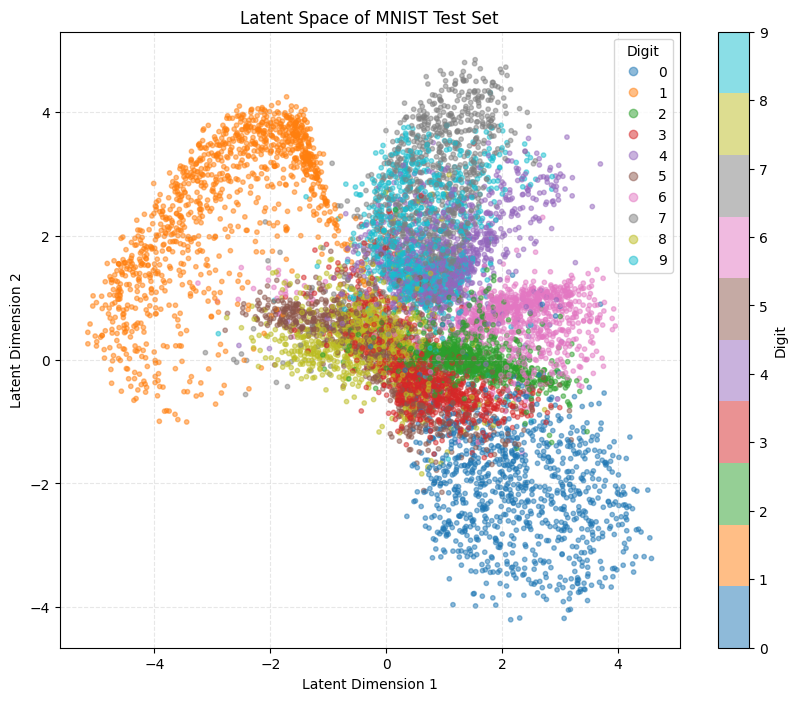

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space(model):
    # Set model to evaluation mode
    # (disables dropout and batch norm, though not used here)
    model.eval()

    # Collect latent representations for the full test set without gradient tracking
    mean_all, y_all = [], []
    with torch.no_grad():
        for x, y in test_loader:  # Loop through entire test set
            # Move data to the appropriate device and flatten images
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            x_flat = x.view(-1, INPUT_SIZE)

            # Encode to get latent means (discard log variances)
            mean, _ = model.encode(x_flat)

            # Move to CPU and convert to NumPy for plotting
            mean_all.append(mean.cpu().numpy())
            y_all.append(y.cpu().numpy())

    # Concatenate all batches into single arrays
    mean_all = np.concatenate(mean_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    print(f"Latent space shape: {mean_all.shape}, Labels shape: {y_all.shape}")

    # Create scatter plot of the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mean_all[:, 0], mean_all[:, 1], c=y_all, cmap='tab10', s=10, alpha=0.5)

    # Add colorbar to indicate digit classes
    plt.colorbar(scatter, label='Digit')

    # Set plot titles and labels
    plt.title('Latent Space of MNIST Test Set')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')

    # Add legend for digit classes
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in range(10)],
               title='Digit', loc='best')

    # Add a light grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)

    # Display the plot
    plt.show()

# Plot latent space
plot_latent_space(model)

Notice how the different combinations of `mean` and `log_variance` for each digit are clustered together. Also, observe how digits that are visually similar (e.g., 6 and 8) are closer to each other in the latent space compared to dissimilar digits. 🤔


## Futher Improvements

Want to improve the model further? Try experimenting with these ideas: ✨

*   **Deeper Architecture:** Add more hidden layers to the encoder and decoder.
*   **Larger Hidden Dimensions:** Increase the hidden dimension from `256` to `512` or `1024` for greater capacity.
*   **Convolutional Layers:** Replace fully connected layers with CNNs to better capture spatial patterns in images.
*   **More Latent Features:** Expand the latent space beyond `2` dimensions for richer representations.
*   **Tweak Beta:** Adjust the KL divergence weight to fine-tune the balance between reconstruction and regularization.

These modifications could lead to sharper image reconstructions and more diverse generated digits. 🚀
